<a href="https://colab.research.google.com/github/bilalProgTech/online-data-science-ml-challenges/blob/master/Machine-Hack-Wafer-Manufacturing-Anamolies-Detection-ML-Challenge/Benchmark-Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/detecting_anomalies_in_wafer_manufacturing_weekend_hackathon_18/Participants_Data_WH18.zip
!unzip \*.zip  && rm *.zip

--2020-08-30 11:19:11--  https://machinehack-be.s3.amazonaws.com/detecting_anomalies_in_wafer_manufacturing_weekend_hackathon_18/Participants_Data_WH18.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.64.80
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.64.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114903 (112K) [application/zip]
Saving to: ‘Participants_Data_WH18.zip’

Participants_Data_W 100%[===================>] 112.21K   226KB/s    in 0.5s    

2020-08-30 11:19:13 (226 KB/s) - ‘Participants_Data_WH18.zip’ saved [114903/114903]

Archive:  Participants_Data_WH18.zip
   creating: Participants_Data_WH18/
  inflating: Participants_Data_WH18/Test.csv  
  inflating: __MACOSX/Participants_Data_WH18/._Test.csv  
  inflating: Participants_Data_WH18/Train.csv  
  inflating: __MACOSX/Participants_Data_WH18/._Train.csv  
  inflating: Participants_Data_WH18/Sample_submission.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train = pd.read_csv('/content/Participants_Data_WH18/Train.csv')
test = pd.read_csv('/content/Participants_Data_WH18/Test.csv')
train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(train.drop(['Class'], axis=1), train['Class'], test_size=0.10)
#X = train.drop(['Class'], axis=1)
#y = train['Class']
bool_train_labels = train['Class'] != 0

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, roc_auc_score

In [ ]:
err = []
y_pred_tot_lgm = []

from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       num_leaves=30,
                       random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='auc',
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,-1]
    print("err_lgm: ",roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(test)[:,-1]
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.972411	training's binary_logloss: 0.115031	valid_1's auc: 0.917593	valid_1's binary_logloss: 0.187945
Early stopping, best iteration is:
[23]	training's auc: 0.94124	training's binary_logloss: 0.169547	valid_1's auc: 0.924074	valid_1's binary_logloss: 0.181154
err_lgm:  0.9240740740740742
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.972886	training's binary_logloss: 0.116249	valid_1's auc: 0.969907	valid_1's binary_logloss: 0.128151
Early stopping, best iteration is:
[12]	training's auc: 0.932187	training's binary_logloss: 0.195979	valid_1's auc: 0.980093	valid_1's binary_logloss: 0.173227
err_lgm:  0.9800925925925926
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.972859	training's binary_logloss: 0.114812	valid_1's auc: 0.9	valid_1's binary_logloss: 0.206695
Early stopping, best iteration is:
[17]	training's auc: 0.940

In [ ]:
np.mean(err, 0)

0.9291700960219479

In [ ]:
from xgboost import XGBClassifier

errxgb = []
y_pred_tot_xgb = []

from sklearn.model_selection import KFold,StratifiedKFold

fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = XGBClassifier(boosting_type='gbdt',
                      max_depth=5,
                      learning_rate=0.07,
                      n_estimators=5000,
                      random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='logloss',
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,-1]
    print("err_xgb: ",roc_auc_score(y_val,pred_y))
    errxgb.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(test)[:,-1]
    i = i + 1
    y_pred_tot_xgb.append(pred_test)

[0]	validation_0-logloss:0.637433	validation_1-logloss:0.639368
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
[200]	validation_0-logloss:0.089133	validation_1-logloss:0.217638
Stopping. Best iteration:
[59]	validation_0-logloss:0.122703	validation_1-logloss:0.190871

err_xgb:  0.9222222222222223
[0]	validation_0-logloss:0.63773	validation_1-logloss:0.635014
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
[200]	validation_0-logloss:0.09221	validation_1-logloss:0.128113
Stopping. Best iteration:
[83]	validation_0-logloss:0.116794	validation_1-logloss:0.11509

err_xgb:  0.9740740740740741
[0]	validation_0-logloss:0.637365	validation_1-logloss:0.640369
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will tra

In [ ]:
np.mean(errxgb,0)

0.9124005486968447

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier,Pool, cv
errCB = []
y_pred_tot_cb = []
from sklearn.model_selection import KFold,StratifiedKFold

fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=2020)
i = 1
for train_index, test_index in fold.split(X,y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = CatBoostClassifier(n_estimators=1000,
                           random_state=1994,
                           eval_metric='AUC',
                           learning_rate=0.5, 
                           max_depth=10)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,-1]
    print(i, "err_cb: ",roc_auc_score(y_val,pred_y))
    errCB.append(roc_auc_score(y_val,pred_y))
    pred_test = m.predict_proba(test)[:,-1]
    i = i + 1
    y_pred_tot_cb.append(pred_test)

     |████████████████████████████████| 66.1MB 57kB/s 
0:	test: 0.8001527	test1: 0.8560185	best: 0.8560185 (0)	total: 114ms	remaining: 1m 54s
200:	test: 0.9997514	test1: 0.8351852	best: 0.9074074 (5)	total: 10.7s	remaining: 42.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9074074074
bestIteration = 5

Shrink model to first 6 iterations.
1 err_cb:  0.9074074074074073
0:	test: 0.7899312	test1: 0.9425926	best: 0.9425926 (0)	total: 64.4ms	remaining: 1m 4s
200:	test: 0.9997514	test1: 0.9509259	best: 0.9800926 (6)	total: 11.4s	remaining: 45.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9800925926
bestIteration = 6

Shrink model to first 7 iterations.
2 err_cb:  0.9800925925925925
0:	test: 0.6834994	test1: 0.7398148	best: 0.7398148 (0)	total: 61.4ms	remaining: 1m 1s
200:	test: 0.9996991	test1: 0.8407407	best: 0.9148148 (3)	total: 11.7s	remaining: 46.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9148148148
bestIterat

In [ ]:
np.mean(errCB, 0)

0.916608367626886

In [ ]:
(np.mean(errxgb, 0) + np.mean(err, 0) + np.mean(errCB, 0))/3

0.9193930041152262

In [ ]:
submission = pd.DataFrame()
submission['Class'] = (np.mean(y_pred_tot_lgm, 0)+np.mean(y_pred_tot_xgb, 0)+np.mean(y_pred_tot_cb, 0))/3
submission.to_csv('Stacking.csv', index=False)
submission.head()

,Class
0,0.480789
1,0.021812
2,0.067598
3,0.247244
4,0.656972


In [ ]:
submission.shape, test.shape

((756, 1), (756, 1558))

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile

In [ ]:
neg, pos = np.bincount(train['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 1763
    Positive: 143 (8.11% of total)



In [ ]:
tf.keras.backend.clear_session()

In [ ]:
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            32, activation='relu',
            input_shape=(X.shape[-1],)),
        keras.layers.Dense(
            16, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid',
                          bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                49888     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(X[:10])

array([[0.83250725],
       [0.9926244 ],
       [0.9519987 ],
       [0.87190235],
       [0.8763459 ],
       [0.9746401 ],
       [0.9884372 ],
       [0.9682547 ],
       [0.7824942 ],
       [0.9660274 ]], dtype=float32)

In [ ]:
results = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 3.2497


In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.4273368])

In [ ]:
model = make_model(output_bias = initial_bias)
model.predict(X[:10])

array([[0.03539875],
       [0.0060648 ],
       [0.02967829],
       [0.02413619],
       [0.03456697],
       [0.02407607],
       [0.013338  ],
       [0.0138756 ],
       [0.06540254],
       [0.00810245]], dtype=float32)

In [ ]:
results = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6704


In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X,
    y,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 655ms/step - loss: 0.8312 - accuracy: 0.6093 - precision: 0.0829 - recall: 0.3744 - auc: 0.4463 - val_loss: 0.6153 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1914
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: 0.7151 - accuracy: 0.8607 - precision: 0.1176 - recall: 0.1077 - auc: 0.3879 - val_loss: 0.5724 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1942
Epoch 3/20
1/1 [==============================] - 0s 20ms/step - loss: 0.6945 - accuracy: 0.8619 - precision: 0.1322 - recall: 0.1231 - auc: 0.3948 - val_loss: 0.5364 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2033
Epoch 4/20
1/1 [==============================] - 0s 19ms/step - loss: 0.6515 - accuracy: 0.8537 - precision: 0.0887 - recall: 0.0846 - auc: 0.3781 - val_loss: 0.5059 - val_accuracy: 0.9266 - val_precision: 0.0000e+0

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X,
    y,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/20
1/1 [==============================] - 1s 502ms/step - loss: 0.6667 - accuracy: 0.9172 - precision: 0.2000 - recall: 0.0070 - auc: 0.4124 - val_loss: 0.5091 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1907
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: 0.6064 - accuracy: 0.9168 - precision: 0.4000 - recall: 0.0308 - auc: 0.3923 - val_loss: 0.4570 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2153
Epoch 3/20
1/1 [==============================] - 0s 25ms/step - loss: 0.5099 - accuracy: 0.9187 - precision: 0.5263 - recall: 0.0769 - auc: 0.4160 - val_loss: 0.4151 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2296
Epoch 4/20
1/1 [==============================] - 0s 20ms/step - loss: 0.5358 - accuracy: 0.9174 - precision: 0.4667 - recall: 0.0538 - auc: 0.3932 - val_loss: 0.3783 - val_accuracy: 0.9266 - val_precision: 0.0000e+0

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
                color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
            color=colors[n], label='Val '+label,
            linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.legend()

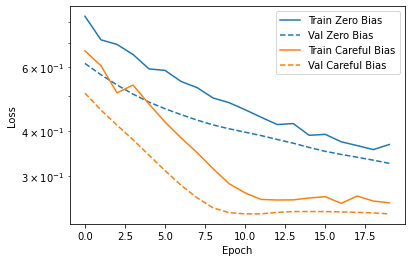

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X,
    y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/100
1/1 [==============================] - 1s 526ms/step - loss: 0.6767 - accuracy: 0.9189 - precision: 0.5000 - recall: 0.0210 - auc: 0.4180 - val_loss: 0.5087 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1935
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.6016 - accuracy: 0.9168 - precision: 0.4375 - recall: 0.0538 - auc: 0.3803 - val_loss: 0.4559 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2155
Epoch 3/100
1/1 [==============================] - 0s 20ms/step - loss: 0.5250 - accuracy: 0.9161 - precision: 0.3846 - recall: 0.0385 - auc: 0.3606 - val_loss: 0.4136 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2284
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5084 - accuracy: 0.9149 - precision: 0.2222 - recall: 0.0154 - auc: 0.3254 - val_loss: 0.3768 - val_accuracy: 0.9266 - val_precision: 0.000

In [ ]:
def plot_metrics(history):
    plt.figure(figsize=(15,10))
    metrics =  ['loss', 'accuracy', 'precision', 'auc']
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)

      plt.legend()

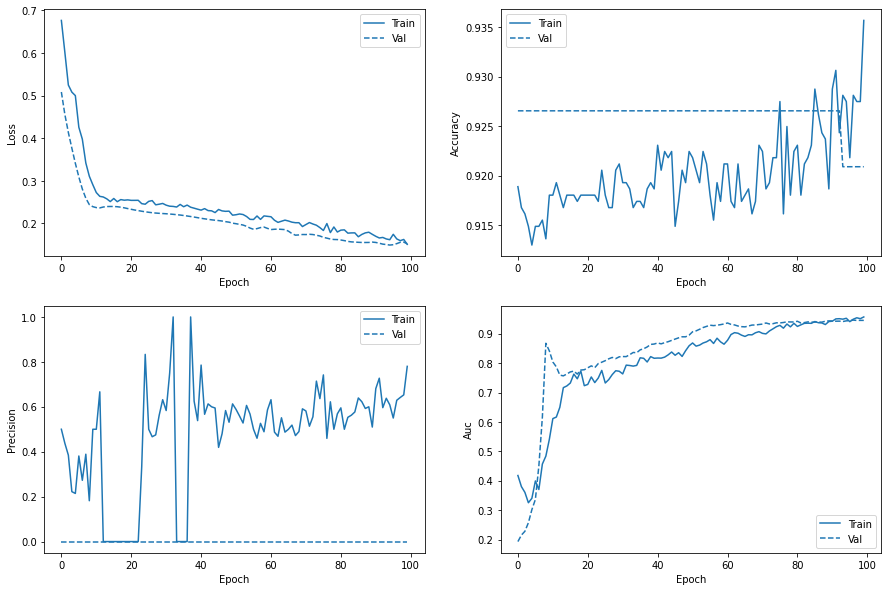

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(X, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total: ', np.sum(cm[1]))

In [ ]:
baseline_results = model.evaluate(X, y,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.13956674933433533
accuracy :  0.9287515878677368
precision :  0.7931034564971924
recall :  0.17692308127880096
auc :  0.9681794047355652



loss :  0.15233156085014343
accuracy :  0.9209039807319641
precision :  0.0
recall :  0.0
auc :  0.9451219439506531

(True Negatives):  163
(False Positives):  1
(False Negatives):  13
(True Positives):  0
Total:  13


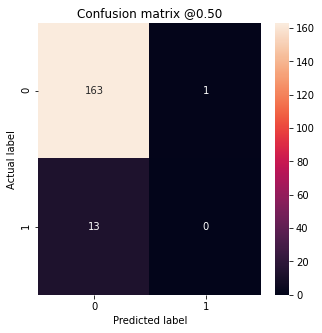

In [ ]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, np.round(np.mean(test_predictions_baseline, 1)).astype('int64'))

In [ ]:
import sklearn
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

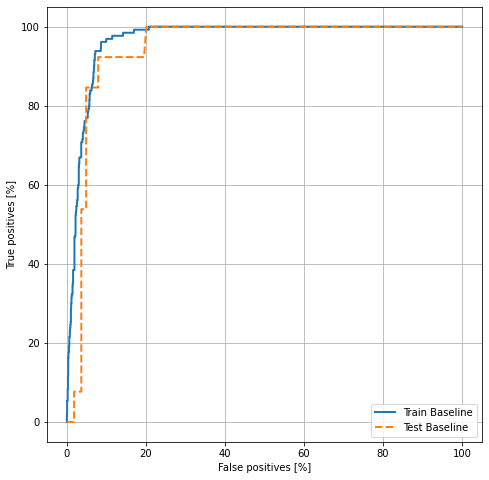

In [ ]:
plt.figure(figsize=(12, 8))
plot_roc("Train Baseline", y, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [ ]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.16


In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X,
    y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight) 

Epoch 1/100
1/1 [==============================] - 1s 520ms/step - loss: 3.8426 - accuracy: 0.9189 - precision: 0.5000 - recall: 0.0210 - auc: 0.4482 - val_loss: 0.5094 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1904
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 3.4177 - accuracy: 0.9155 - precision: 0.3333 - recall: 0.0308 - auc: 0.3683 - val_loss: 0.4573 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2080
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 2.9774 - accuracy: 0.9092 - precision: 0.1818 - recall: 0.0308 - auc: 0.3389 - val_loss: 0.4193 - val_accuracy: 0.9266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2333
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 2.3533 - accuracy: 0.9105 - precision: 0.3000 - recall: 0.0692 - auc: 0.4057 - val_loss: 0.3863 - val_accuracy: 0.9266 - val_precision: 0.000

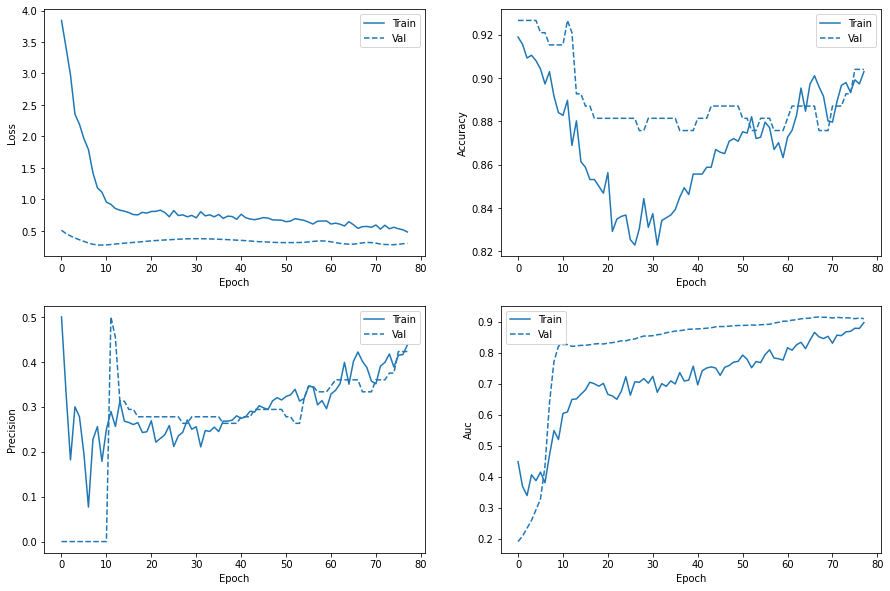

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(X, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.3087049424648285
accuracy :  0.8757061958312988
precision :  0.3333333432674408
recall :  0.692307710647583
auc :  0.9151031970977783

(True Negatives):  146
(False Positives):  18
(False Negatives):  4
(True Positives):  9
Total:  13


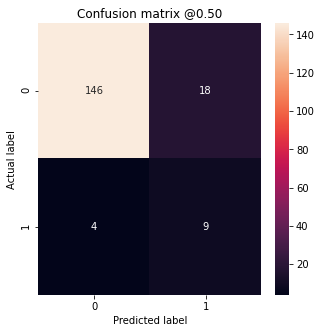

In [ ]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(y_test, np.round(np.mean(test_predictions_weighted, 1)).astype('int64'))

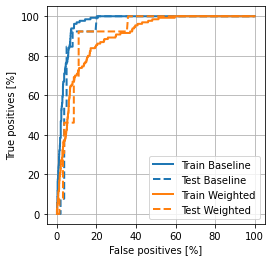

In [ ]:
plot_roc("Train Baseline", y, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend()

In [ ]:
pos_features = X[bool_train_labels].reset_index(drop=True)
neg_features = X[~bool_train_labels].reset_index(drop=True)

pos_labels = y[bool_train_labels].reset_index(drop=True)
neg_labels = y[~bool_train_labels].reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features.iloc[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(1456, 1558)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(2912, 1558)

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [ 60.  468.    7.8 ...   0.    0.    0. ]

Label:  1


In [ ]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.4951171875


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

2.0

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
2/2 [==============================] - 0s 229ms/step - loss: 2.7671 - accuracy: 0.5256 - precision: 0.4991 - recall: 0.1347 - auc: 0.3755 - val_loss: 0.6614 - val_accuracy: 0.8305 - val_precision: 0.0526 - val_recall: 0.0769 - val_auc: 0.2104
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 2.1351 - accuracy: 0.4622 - precision: 0.4531 - recall: 0.2297 - auc: 0.3680 - val_loss: 0.7187 - val_accuracy: 0.6497 - val_precision: 0.0545 - val_recall: 0.2308 - val_auc: 0.2629
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 1.5439 - accuracy: 0.4399 - precision: 0.4331 - recall: 0.3465 - auc: 0.3810 - val_loss: 0.7358 - val_accuracy: 0.5876 - val_precision: 0.0588 - val_recall: 0.3077 - val_auc: 0.3361
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 1.0755 - accuracy: 0.4546 - precision: 0.4572 - recall: 0.4742 - auc: 0.4395 - val_loss: 0.7603 - val_accuracy: 0.4068 - val_precision: 0.0893 - val_recall: 0.7692 -

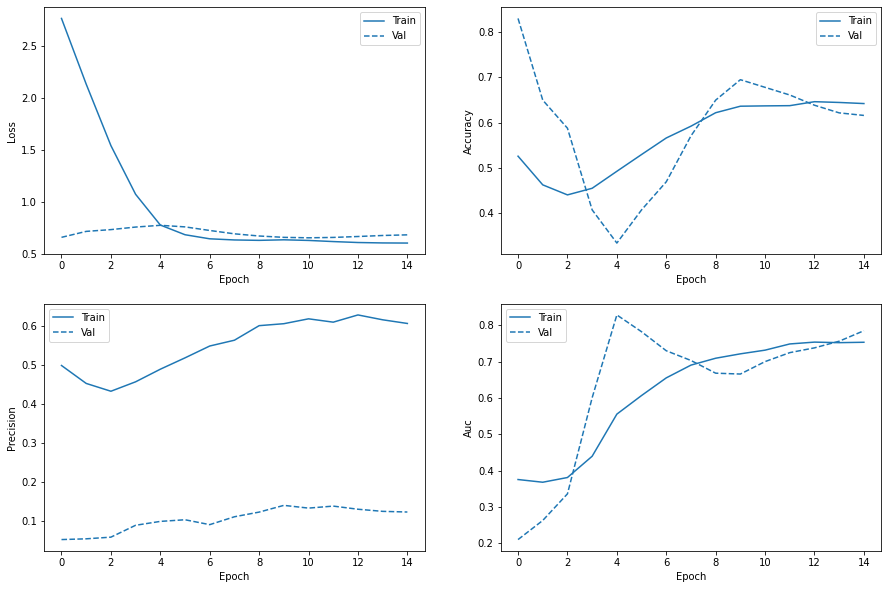

In [ ]:
plot_metrics(resampled_history)

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 1s 66ms/step - loss: 1.1378 - accuracy: 0.5301 - precision: 0.5292 - recall: 0.5616 - auc: 0.5471 - val_loss: 0.6688 - val_accuracy: 0.6780 - val_precision: 0.1333 - val_recall: 0.6154 - val_auc: 0.6907
Epoch 2/1000
20/20 [==============================] - 1s 46ms/step - loss: 0.5990 - accuracy: 0.6710 - precision: 0.6405 - recall: 0.7830 - auc: 0.7725 - val_loss: 0.6257 - val_accuracy: 0.6836 - val_precision: 0.1587 - val_recall: 0.7692 - val_auc: 0.8455
Epoch 3/1000
20/20 [==============================] - 1s 48ms/step - loss: 0.5073 - accuracy: 0.7661 - precision: 0.8034 - recall: 0.7043 - auc: 0.8604 - val_loss: 0.4020 - val_accuracy: 0.8927 - val_precision: 0.4000 - val_recall: 0.9231 - val_auc: 0.9303
Epoch 4/1000
20/20 [==============================] - 1s 46ms/step - loss: 0.3899 - accuracy: 0.8352 - precision: 0.8708 - recall: 0.7875 - auc: 0.9213 - val_loss: 0.2903 - val_accuracy: 0.9209 - val_precision: 0.4800 - val_recal

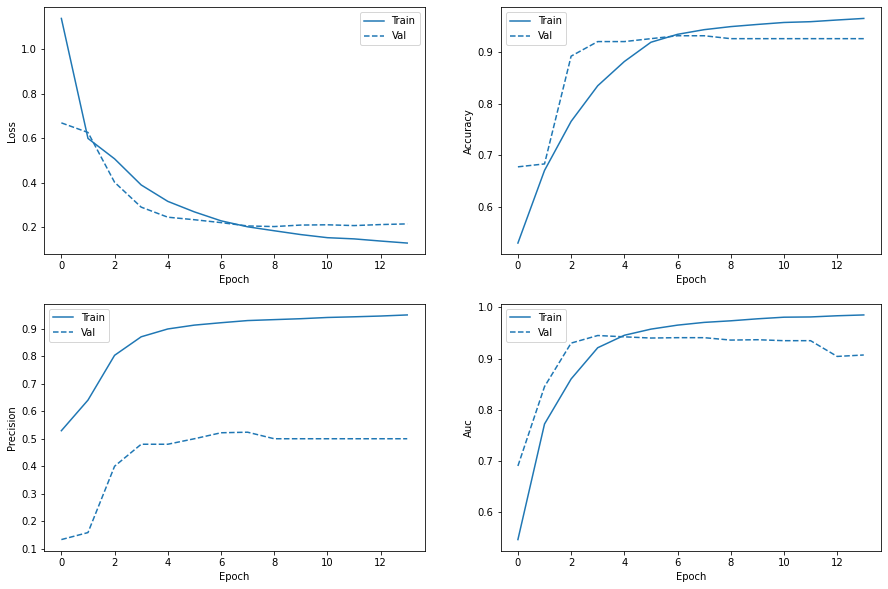

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(X, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.2902928590774536
accuracy :  0.9209039807319641
precision :  0.47999998927116394
recall :  0.9230769276618958
auc :  0.9451219439506531

(True Negatives):  151
(False Positives):  13
(False Negatives):  1
(True Positives):  12
Total:  13


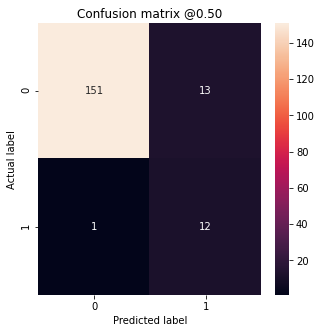

In [ ]:
resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(y_test, np.round(np.mean(test_predictions_resampled, 1)).astype('int64'))

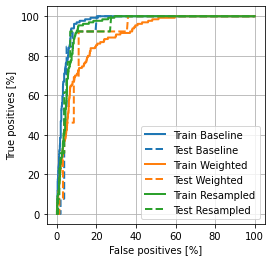

In [ ]:
plot_roc("Train Baseline", y, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", y, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", y_test, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend()

In [ ]:
test_pred = resampled_model.predict(test, batch_size=BATCH_SIZE)
df_result = pd.DataFrame()

df_result['Class'] = np.mean(test_pred, 1)
print(df_result.shape, test.shape)
df_result.to_csv('tf1_5.csv', index=False)
df_result.head()

(756, 1) (756, 1558)


,Class
0,0.871093
1,0.070056
2,0.544910
3,0.882870
4,0.688548


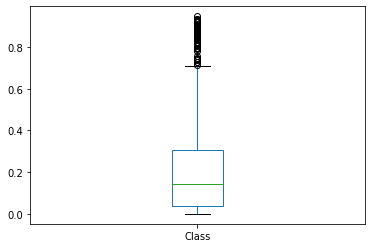

In [ ]:
df_result['Class'].plot.box()